In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [30]:
models_results = pd.read_csv('../Data/models_results.csv')

In [3]:
models_results.columns

Index(['Model', 'CV_MSE', 'CV_RMSE', 'CV_R2', 'MSE_train', 'RMSE_train',
       'MSE_test', 'RMSE_test', 'R2_train', 'R2_test'],
      dtype='object')

In [4]:
maximize = ['CV_R2', 'R2_train', 'R2_test']
minimize = [x for x in models_results.columns[1:] if x not in maximize]

In [37]:
def highlight_value(s):
    if s.name in maximize:
        mask = s == s.max()
    elif s.name in minimize:
        mask = s == s.min()
    else:
        mask = s.isna()
    return ['background-color: yellow' if v else '' for v in mask]

In [38]:
highlighted_models_results = models_results.copy()
highlighted_models_results.style.apply(highlight_value)

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test
0,Baseline,nan,nan,nan,8593944992.245739,92703.532793,8607588916.739229,92777.092629,0.000000,0.000000
1,LinearRegression+Data_lr+StandardScaler,3639278072.264776,60326.429301,0.576941,3429409551.327261,58561.160775,4250756476.458890,65197.825703,0.600950,0.506162
2,LinearRegression+Data_lr+MinMaxScaler,3641515217.369488,60344.968451,0.576679,3430432126.609660,58569.890956,4238982720.827599,65107.470545,0.600832,0.507530
3,LinearRegression+Data_lr+RobustScaler,3639464238.104510,60327.972269,0.576915,3429926339.002779,58565.572984,4239003314.138617,65107.628694,0.600890,0.507527
4,LinearRegression+Data_lr+None,3640170929.742506,60333.829066,0.576834,3429307697.827183,58560.291135,4238062531.088125,65100.403463,0.600962,0.507637
5,LinearRegression+Data+StandardScaler,3640275923.925242,60334.699170,0.576822,3430676286.373981,58571.975264,4239122583.192366,65108.544625,0.600803,0.507513
6,LinearRegression+Data+MinMaxScaler,3641298630.919502,60343.173855,0.576703,3430780662.790205,58572.866267,4247853703.425696,65175.560630,0.600791,0.506499
7,LinearRegression+Data+RobustScaler,3639204567.702811,60325.820075,0.576944,3429926339.002779,58565.572984,4239003314.138632,65107.628694,0.600890,0.507527
8,LinearRegression+Data+None,3639810299.965523,60330.840372,0.576875,3429517096.711166,58562.078999,4238075303.042055,65100.501558,0.600938,0.507635
9,LinearRegression+Data_p2+StandardScaler,3080144834.044545,55499.052551,0.642240,2669494984.941751,51667.155766,3577983832.263581,59816.250570,0.689375,0.584322


Как видно, Catboost показывает наилучшие результаты, хотя модель все еще несколько переобучена.

In [39]:
train_data_ne = pd.read_csv('../Data/train_data_with_feats.csv')
test_data_ne = pd.read_csv('../Data/test_data_with_feats.csv')

In [40]:
def cat_feats_encode(df, cat_feats):
    result = df.copy()
    for cat in cat_feats:
        result[cat] = result[cat].replace({'A': 0, 'B': 1})
    return result

In [41]:
cat_feats = ['Ecology_2', 'Ecology_3', 'Shops_2']
train_data = cat_feats_encode(train_data_ne, cat_feats)
test_data = cat_feats_encode(test_data_ne, cat_feats)
y_train = train_data['Price']
y_test = test_data['Price']
X_train = train_data.drop(['DistrictId', 'Price'], axis=1)
X_test = test_data.drop(['DistrictId', 'Price'], axis=1)

In [47]:
X_for_CV = pd.concat([X_train, X_test]).reset_index(drop=True)
y_for_CV = pd.concat([y_train, y_test]).reset_index(drop=True)

In [49]:
from sklearn.model_selection import KFold
from sklearn.base import clone

In [178]:
def regression_CV(estimator, X, y, cv=3, return_train_score=False, return_r2_score=False, return_estimator=False,
                                return_single_mse=False):
    if isinstance(X, pd.core.frame.DataFrame):
        X = X.values
    if isinstance(y, pd.core.frame.DataFrame):
        y = y.values
    results = {}
    results['mse_test'] = []
    if return_r2_score:
        results['r2_test'] = []
        if return_train_score:
            results['r2_train'] = []
    if return_train_score:
        results['mse_train'] = []
    if return_estimator:
        results['estimator'] = []
    if return_single_mse:
        results['single_mse'] = []
    k_fold = KFold(cv)
    for fold, (train, test) in enumerate(k_fold.split(X, y)):
        model = clone(estimator)
        model.fit(X[train], y[train])
        y_pred_train = model.predict(X[train])
        y_pred_test = model.predict(X[test])
        mse_train = mean_squared_error(y[train], y_pred_train)
        mse_test = mean_squared_error(y[test], y_pred_test)
        results['mse_test'].append(mse_test)
        
        if return_estimator:
            results['estimator'].append(model)
            
        if return_r2_score:
            results['r2_test'].append(r2_score(y[test], y_pred_test))
            if return_train_score:
                results['r2_train'].append(r2_score(y[train], y_pred_train))
    
        if return_train_score:
            results['mse_train'].append(mse_train)
        
        if return_single_mse:
            train_mse_singles = []
            test_mse_singles = []
            for n, k in zip(train, range(len(y_pred_train))):
                mse_ = mean_squared_error([y[n]], [y_pred_train[k]])
                train_mse_singles.append((n, mse_))
            for n, k in zip(test, range(len(y_pred_test))):
                mse_ = mean_squared_error([y[n]], [y_pred_test[k]])
                test_mse_singles.append((n, mse_))
                    
            train_mse_singles = pd.DataFrame(train_mse_singles, columns=['index_train_fold_'+str(fold), 'mse_train_fold_'+str(fold)])
            test_mse_singles = pd.DataFrame(test_mse_singles, columns=['index_test_fold_'+str(fold), 'mse_test_fold_'+str(fold)])
            results['single_mse'].append({'fold': fold, 'train_mse_singles': train_mse_singles, 'test_mse_singles': test_mse_singles})
            
    return results

In [179]:
model = CatBoostRegressor(silent=True)

In [180]:
%%time
results_cv = regression_CV(model, X_for_CV, y_for_CV, return_train_score=True, return_r2_score=True, return_estimator=True, return_single_mse=True)

Wall time: 18.7 s


In [204]:
def find_outliers(results_cv):
    result = results_cv.copy()
    for fold in results_cv['single_mse']:
        df_train = fold['train_mse_singles']
        df_test = fold['test_mse_singles']
        for data in [df_train, df_test]:
            out = 3*data[data.columns[1]].std()
            data['outliers'] = data[data.columns[1]].apply(lambda x: 'out' if x > out else 'in')
    
    return result

In [205]:
results_cv = find_outliers(results_cv)

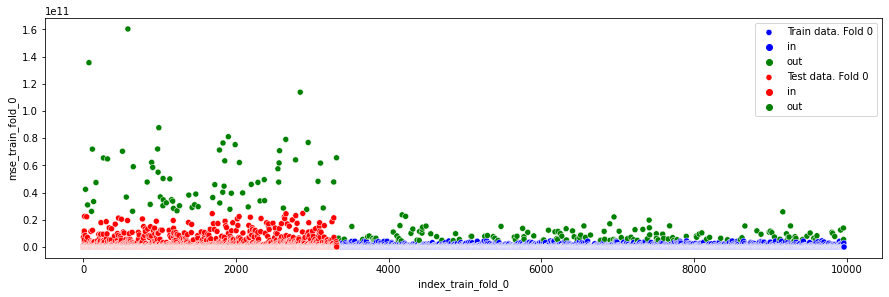

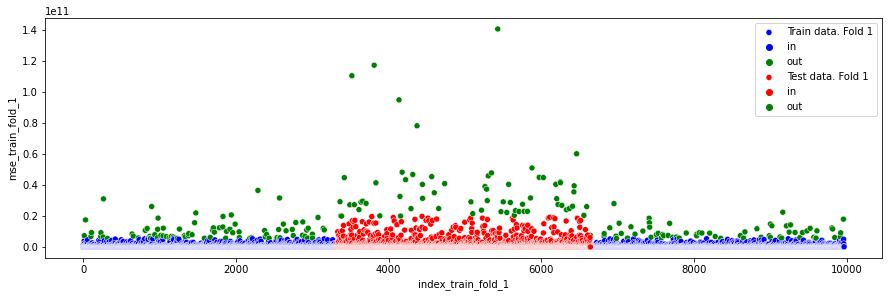

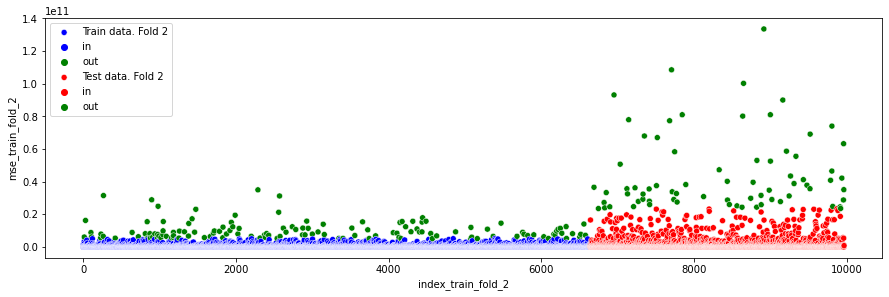

In [207]:
def plot_mse(results_cv, highlight_outliers=False):
    result = results_cv.copy()
    plots = len(result['mse_train'])
    if highlight_outliers:
        result = find_outliers(result)
    for n, fold in enumerate(result['single_mse']):
        df_train = fold['train_mse_singles']
        df_test = fold['test_mse_singles']        
        plt.figure(figsize=(15,15))
        plt.subplot(plots, 1, n+1)
        sns.scatterplot(data=df_train, x=df_train.columns[0], y=df_train.columns[1], 
                        hue=df_train['outliers'] if highlight_outliers else None,
                        label='Train data. Fold '+str(fold['fold']), palette=['blue', 'green'])
        sns.scatterplot(data=df_test, x=df_test.columns[0], y=df_test.columns[1], 
                        hue=df_test['outliers'] if highlight_outliers else None,
                        label='Test data. Fold '+str(fold['fold']), palette=['red', 'green'])
        plt.legend()
        
plot_mse(results_cv, True)

In [218]:
out_index = []
for fold in results_cv['single_mse']:
    df_train = fold['train_mse_singles']
    df_test = fold['test_mse_singles']
    out_index.extend(df_train[df_train.columns[0]].loc[df_train['outliers'] == 'out'])
    out_index.extend(df_test[df_test.columns[0]].loc[df_test['outliers'] == 'out'])
    
out_index = np.unique(out_index)

In [219]:
len(out_index)

364

In [221]:
columns = pd.read_csv('../Data/train.csv').columns

In [223]:
data = pd.concat([X_for_CV, y_for_CV], axis=1)

In [233]:
out_df = data.iloc[out_index][[x for x in data.columns.tolist() if x in columns.tolist()]]

In [235]:
pd.options.display.max_rows = len(out_index)
out_df.sort_values(by='Square', ascending=False)

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
168,4.0,200.334539,25.0,1.0,2.0,2013,4.111635e-02,1,1,53,4,1,4,1,528560.506016
4733,3.0,190.857689,19.0,7.0,7.0,2007,0.000000e+00,1,1,23,4,2,6,1,338644.075979
9802,5.0,183.382273,15.0,2.0,6.0,1997,9.079910e-02,1,1,74,2,5,15,1,622888.825328
2550,1.0,174.649522,15.0,10.0,12.0,1958,2.361085e-01,1,1,16,27,3,10,1,232766.187698
515,3.0,156.636577,1.0,1.0,3.0,2005,7.215758e-02,1,1,2,1,0,0,0,502523.573863
3550,3.0,138.980817,43.0,2.0,2.0,1977,4.378852e-01,1,1,23,3,0,5,1,169528.896664
76,3.0,129.998756,11.0,21.0,22.0,2012,2.386171e-01,1,1,26,6,3,6,1,132176.743972
7031,3.0,127.141143,1.0,3.0,3.0,2017,1.116274e-01,1,1,50,8,2,3,1,611250.912034
2842,3.0,126.621358,12.0,22.0,48.0,2011,1.116274e-01,1,1,50,8,2,3,1,179396.521035
1172,3.0,122.803190,17.0,6.0,18.0,2015,3.270180e-01,1,1,12,23,1,0,1,203176.229568


In [236]:
from sklearn.model_selection import cross_validate

In [303]:
def model_fit_results(estimator, model_name, data_list, scaler_list, feats_not_to_scale, df_for_results):
    df_res = df_for_results.copy()
    for name, X_train, X_test, y_train, y_test in data_list:
        feats_to_scale = [x for x in X_train.columns if x not in feats_not_to_scale]
        for sc in scaler_list:
            if not isinstance(sc, str):
                scaler = clone(sc)              
                X_train_scaled = np.hstack((scaler.fit_transform(X_train[feats_to_scale]), X_train.drop(feats_to_scale, axis=1).values))
                X_test_scaled = np.hstack((scaler.transform(X_test[feats_to_scale]), X_test.drop(feats_to_scale, axis=1).values))
                scaler_name = scaler.__str__()[:-2]
            elif sc == 'None':
                X_train_scaled = X_train
                X_test_scaled = X_test
                scaler_name = sc
            model = clone(estimator)
            model_cv_results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring=['r2', 'neg_mean_squared_error'], return_estimator=True)
            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
            model_mse_train = mean_squared_error(y_train, y_pred_train)
            model_mse_test = mean_squared_error(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            model_results = pd.DataFrame({'Model': [model_name + '+' + name + '+' + scaler_name], 'CV_MSE': [abs(model_cv_results['test_neg_mean_squared_error'].mean())], 
                                  'CV_RMSE': [abs(model_cv_results['test_neg_mean_squared_error'].mean())**0.5], 
                                  'CV_R2': [model_cv_results['test_r2'].mean()], 'MSE_train': [model_mse_train], 
                                  'RMSE_train': [model_mse_train**0.5], 
                                  'MSE_test': [model_mse_test], 'RMSE_test': [model_mse_test**0.5], 'R2_train': [r2_train], 
                                  'R2_test': [r2_test], 'fit_time': [model_cv_results['fit_time'].mean()]})
            df_res = pd.concat([df_res, model_results], axis=0).reset_index(drop=True)
    
    return df_res

In [268]:
X = data.drop('Price', axis=1).drop(out_index, axis=0).reset_index(drop=True)
y = data['Price'].drop(out_index, axis=0).reset_index(drop=True)

In [240]:
from sklearn.model_selection import train_test_split

In [308]:
data_list = [('Data', *train_test_split(X, y, test_size=0.3, random_state=42))]

In [309]:
%%time
results_without_outliers = model_fit_results(model, 'CatBoostRegressor', data_list, scaler_list=['None'], feats_not_to_scale=[], df_for_results=pd.DataFrame({}))

Wall time: 19.8 s


In [310]:
results_without_outliers

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test,fit_time
0,CatBoostRegressor+Data+None,1.031500e+09,32116.975298,0.866296,2.943172e+08,17155.676244,8.663999e+08,29434.671387,0.96189,0.88748,4.783678


In [269]:
res_cv_wo = regression_CV(model, X, y, return_estimator=True)

In [253]:
from sklearn.model_selection import GridSearchCV

In [280]:
data_to_plot = []
for estimator in res_cv_wo['estimator']:
    data_to_plot.append(pd.DataFrame({'x': estimator.feature_importances_, 'y': X.columns}).sort_values(by='x', ascending=False))

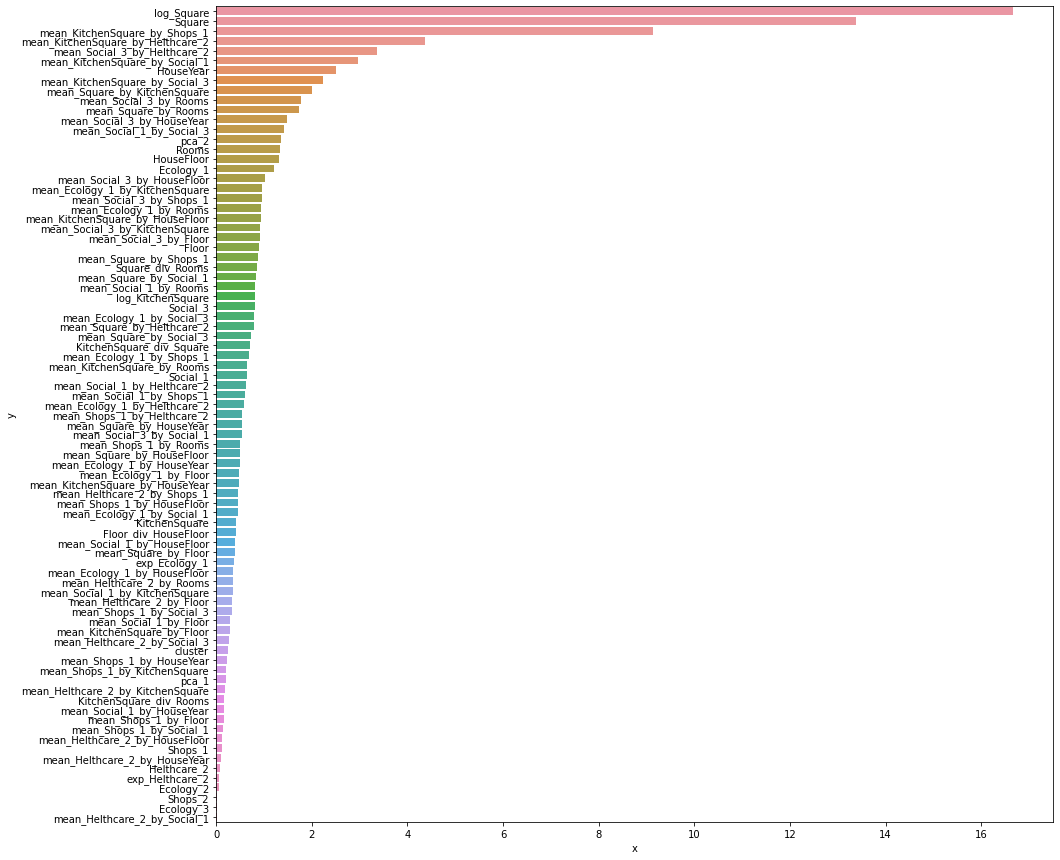

In [283]:
plt.figure(figsize=(15,15))
sns.barplot(data = data_to_plot[0], x='x', y='y')
plt.show()

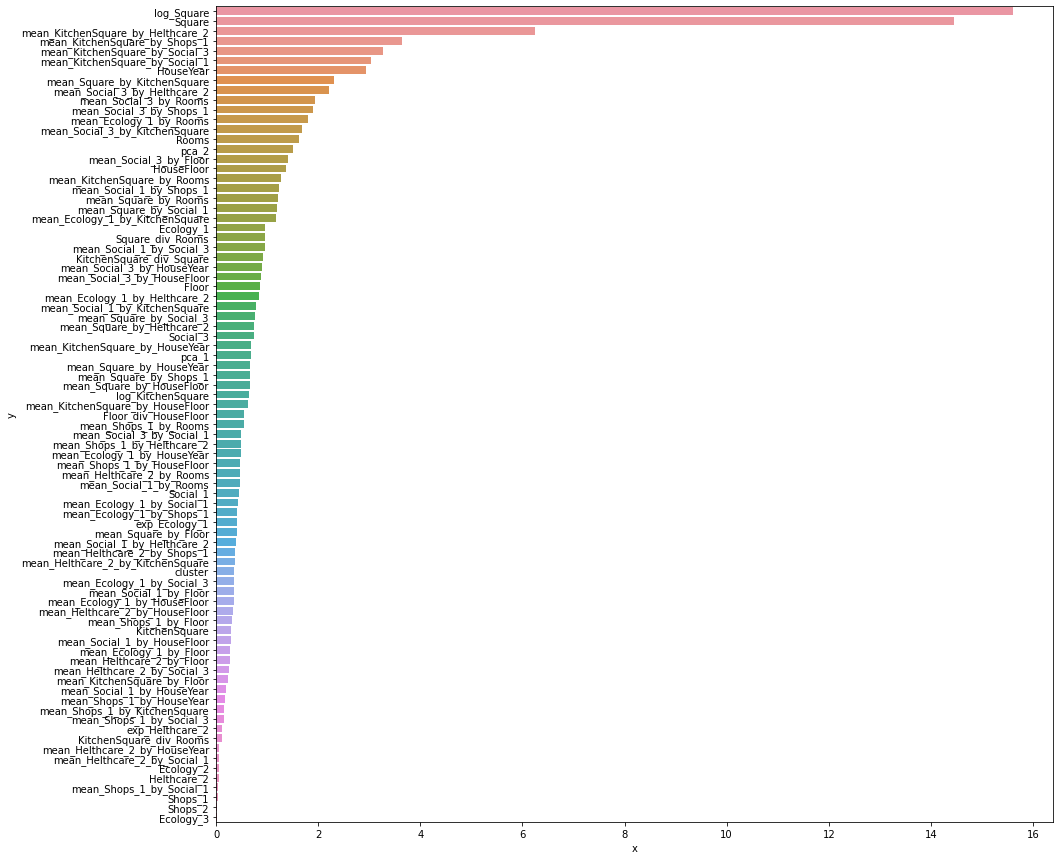

In [284]:
plt.figure(figsize=(15,15))
sns.barplot(data = data_to_plot[1], x='x', y='y')
plt.show()

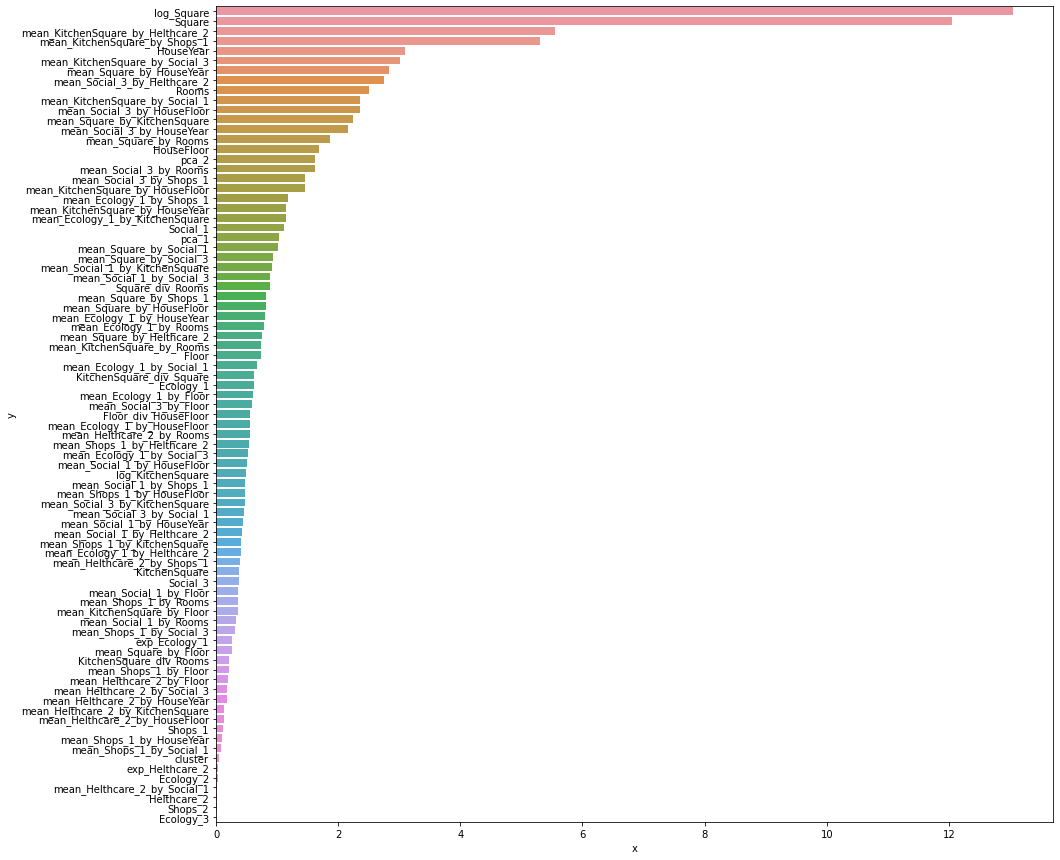

In [285]:
plt.figure(figsize=(15,15))
sns.barplot(data = data_to_plot[2], x='x', y='y')
plt.show()

In [290]:
data_to_plot[0].loc[data_to_plot[0]['x']>0.35]['x'].sum()/data_to_plot[0]['x'].sum()

0.9584030427705753

In [292]:
features_select_from = []
for data in data_to_plot:
    features_select_from.extend(data.loc[data['x']>0.35]['y'].tolist())
features_select_from = np.unique(features_select_from)

In [293]:
len(features_select_from)

67

In [274]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression

In [279]:
def feature_selection(X, y, k=5, percentile=10, models_list=None):
    columns = []
    skb = SelectKBest(f_regression, k=k)
    skb.fit(X, y)
    columns.extend(X.columns[skb.get_support()].tolist())
    sp = SelectPercentile(f_regression, percentile=percentile)
    sp.fit(X, y)
    columns.extend(X.columns[sp.get_support()].tolist())
    if models_list:
        for model in models_list:
            sfm = SelectFromModel(model, max_features=k)
            sfm.fit(X, y)
            columns.extend(X.columns[sfm.get_support()].tolist())
    
    return np.unique(columns)

In [311]:
%%time
count = 1
for n_feats in range(len(features_select_from)-1, 4, -1):
    columns = feature_selection(X, y, k=n_feats, percentile=n_feats*100//len(features_select_from), models_list=res_cv_wo['estimator'])
    data_list = [('Data_'+str(n_feats), *train_test_split(X[columns], y, test_size=0.3, random_state=42))]
    results_without_outliers = model_fit_results(model, 'CatBoostRegressor', data_list, scaler_list=['None'], 
                                                 feats_not_to_scale=[], df_for_results=results_without_outliers)
    if results_without_outliers.iloc[count]['CV_MSE']/results_without_outliers.iloc[0]['CV_MSE'] > 1.05:
        break
    count += 1

Wall time: 21min 26s


In [312]:
results_without_outliers

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test,fit_time
0,CatBoostRegressor+Data+None,1.031500e+09,32116.975298,0.866296,2.943172e+08,17155.676244,8.663999e+08,29434.671387,0.961890,0.887480,4.783678
1,CatBoostRegressor+Data_66+None,1.020725e+09,31948.780916,0.867664,2.976664e+08,17253.012123,8.627973e+08,29373.411991,0.961457,0.887948,5.181706
2,CatBoostRegressor+Data_65+None,1.020725e+09,31948.780916,0.867664,2.976664e+08,17253.012123,8.627973e+08,29373.411991,0.961457,0.887948,5.696539
3,CatBoostRegressor+Data_64+None,1.019358e+09,31927.393043,0.867762,2.961472e+08,17208.927490,8.616528e+08,29353.922492,0.961653,0.888097,5.737916
4,CatBoostRegressor+Data_63+None,1.019358e+09,31927.393043,0.867762,2.961472e+08,17208.927490,8.616528e+08,29353.922492,0.961653,0.888097,5.624028
5,CatBoostRegressor+Data_62+None,1.015379e+09,31865.016176,0.868349,2.976993e+08,17253.964250,8.641276e+08,29396.047193,0.961452,0.887775,5.575535
6,CatBoostRegressor+Data_61+None,1.015379e+09,31865.016176,0.868349,2.976993e+08,17253.964250,8.641276e+08,29396.047193,0.961452,0.887775,5.565703
7,CatBoostRegressor+Data_60+None,1.007018e+09,31733.543103,0.869450,2.964142e+08,17216.685088,8.704942e+08,29504.138321,0.961619,0.886948,5.548369
8,CatBoostRegressor+Data_59+None,1.007018e+09,31733.543103,0.869450,2.964142e+08,17216.685088,8.704942e+08,29504.138321,0.961619,0.886948,5.424010
9,CatBoostRegressor+Data_58+None,1.033670e+09,32150.734863,0.866017,3.012209e+08,17355.715791,8.692391e+08,29482.860991,0.960996,0.887111,5.494928


In [314]:
results_without_outliers.sort_values(by='CV_MSE')

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test,fit_time
8,CatBoostRegressor+Data_59+None,1.007018e+09,31733.543103,0.869450,2.964142e+08,17216.685088,8.704942e+08,29504.138321,0.961619,0.886948,5.424010
7,CatBoostRegressor+Data_60+None,1.007018e+09,31733.543103,0.869450,2.964142e+08,17216.685088,8.704942e+08,29504.138321,0.961619,0.886948,5.548369
16,CatBoostRegressor+Data_51+None,1.015003e+09,31859.104801,0.868415,3.002619e+08,17328.065909,8.762432e+08,29601.405616,0.961120,0.886202,3.995696
5,CatBoostRegressor+Data_62+None,1.015379e+09,31865.016176,0.868349,2.976993e+08,17253.964250,8.641276e+08,29396.047193,0.961452,0.887775,5.575535
6,CatBoostRegressor+Data_61+None,1.015379e+09,31865.016176,0.868349,2.976993e+08,17253.964250,8.641276e+08,29396.047193,0.961452,0.887775,5.565703
3,CatBoostRegressor+Data_64+None,1.019358e+09,31927.393043,0.867762,2.961472e+08,17208.927490,8.616528e+08,29353.922492,0.961653,0.888097,5.737916
4,CatBoostRegressor+Data_63+None,1.019358e+09,31927.393043,0.867762,2.961472e+08,17208.927490,8.616528e+08,29353.922492,0.961653,0.888097,5.624028
11,CatBoostRegressor+Data_56+None,1.019612e+09,31931.356184,0.867785,2.970658e+08,17235.596124,8.789867e+08,29647.710399,0.961534,0.885846,5.638902
17,CatBoostRegressor+Data_50+None,1.020686e+09,31948.172424,0.867650,2.995193e+08,17306.626984,8.695065e+08,29487.395131,0.961217,0.887077,4.161335
1,CatBoostRegressor+Data_66+None,1.020725e+09,31948.780916,0.867664,2.976664e+08,17253.012123,8.627973e+08,29373.411991,0.961457,0.887948,5.181706


In [316]:
from sklearn.model_selection import ShuffleSplit

In [332]:
%%time
for i in range(10):
    columns = feature_selection(X, y, k=51, percentile=51*100//len(features_select_from), models_list=res_cv_wo['estimator'])
    cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=i)
    k = cross_validate(model, X[columns], y, scoring=['r2', 'neg_mean_squared_error'], cv=cv)
    print('MSE: {}. R2: {}. Fit time: {}'.format(np.mean(abs(k['test_neg_mean_squared_error'])), np.mean(k['test_r2']), np.mean(k['fit_time'])))

MSE: 950754839.512242. R2: 0.8813024332945268. Fit time: 4.022680759429932
MSE: 924036579.0027775. R2: 0.8814387167642478. Fit time: 4.040669361750285
MSE: 961755057.0096426. R2: 0.8716276494781434. Fit time: 4.123365561167399
MSE: 899599784.3926115. R2: 0.8824279282276827. Fit time: 4.198969046274821
MSE: 889222319.6890163. R2: 0.8855217188875715. Fit time: 4.461508671442668
MSE: 929075117.494867. R2: 0.8795821944692491. Fit time: 4.005672454833984
MSE: 935939668.5206949. R2: 0.8790281379346032. Fit time: 4.116017500559489
MSE: 957299555.6335436. R2: 0.8763232855425637. Fit time: 4.22303827603658
MSE: 961592420.6482509. R2: 0.8768113895646558. Fit time: 4.135338544845581
MSE: 953592001.3149103. R2: 0.875933994946895. Fit time: 4.129677931467692
Wall time: 4min 32s


In [395]:
param_grid = {'iterations': [1000, 1500], 'l2_leaf_reg': [3, 5, 7],
              'depth': [5, 10, None], 'score_function': ['Cosine', 'NewtonCosine'], 'od_pval': [0, 0.0001, 1e-8]}

In [341]:
columns = feature_selection(X, y, k=51, percentile=51*100//len(features_select_from), models_list=res_cv_wo['estimator'])

In [394]:
estimator = CatBoostRegressor(silent=True)

In [397]:
%%time
grid_search_results = estimator.grid_search(param_grid, X[columns], y, cv=3, train_size=0.7)


bestTest = 31720.23427
bestIteration = 999

0:	loss: 31720.2342728	best: 31720.2342728 (0)	total: 3.2s	remaining: 5m 42s

bestTest = 31910.25231
bestIteration = 999

1:	loss: 31910.2523116	best: 31720.2342728 (0)	total: 6.47s	remaining: 5m 42s

bestTest = 31886.58207
bestIteration = 999

2:	loss: 31886.5820712	best: 31720.2342728 (0)	total: 9.34s	remaining: 5m 26s

bestTest = 31145.4906
bestIteration = 1499

3:	loss: 31145.4905987	best: 31145.4905987 (3)	total: 13.9s	remaining: 6m

bestTest = 31307.32886
bestIteration = 1498

4:	loss: 31307.3288564	best: 31145.4905987 (3)	total: 18.1s	remaining: 6m 13s

bestTest = 31204.92167
bestIteration = 1499

5:	loss: 31204.9216680	best: 31145.4905987 (3)	total: 22.6s	remaining: 6m 24s

bestTest = 31384.04142
bestIteration = 999

6:	loss: 31384.0414152	best: 31145.4905987 (3)	total: 25.3s	remaining: 6m 5s

bestTest = 31440.68916
bestIteration = 999

7:	loss: 31440.6891577	best: 31145.4905987 (3)	total: 28.2s	remaining: 5m 52s

bestTest = 31597.72


bestTest = 31780.36012
bestIteration = 1497

65:	loss: 31780.3601201	best: 30715.8501720 (21)	total: 33m 15s	remaining: 21m 9s

bestTest = 30727.05082
bestIteration = 991

66:	loss: 30727.0508231	best: 30715.8501720 (21)	total: 34m 3s	remaining: 20m 50s

bestTest = 30911.82556
bestIteration = 962

67:	loss: 30911.8255574	best: 30715.8501720 (21)	total: 34m 49s	remaining: 20m 29s

bestTest = 30890.40612
bestIteration = 999

68:	loss: 30890.4061199	best: 30715.8501720 (21)	total: 35m 36s	remaining: 20m 7s

bestTest = 30715.85017
bestIteration = 1086

69:	loss: 30715.8501720	best: 30715.8501720 (21)	total: 36m 46s	remaining: 19m 57s

bestTest = 30860.56546
bestIteration = 1422

70:	loss: 30860.5654611	best: 30715.8501720 (21)	total: 37m 56s	remaining: 19m 46s

bestTest = 30872.94601
bestIteration = 1332

71:	loss: 30872.9460098	best: 30715.8501720 (21)	total: 39m 6s	remaining: 19m 33s
Estimating final quality...
Wall time: 44min 32s


In [410]:
pd.DataFrame(grid_search_results['params'], index=[0]).to_csv('../Data/best_params.csv', index=False)

In [406]:
grid_search_results['params']

{'od_pval': 0,
 'depth': 10,
 'l2_leaf_reg': 3,
 'iterations': 1500,
 'score_function': 'NewtonCosine'}